In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [2]:
# Read all the data we have

train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [3]:
# Check the missing data

def missing(df):
 data = pd.DataFrame(df)
 df_cols = list(pd.DataFrame(data))

 dict_x = {}
 for i in range(0, len(df_cols)):
  dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100, 2)})
 
 return dict_x

missing_data = missing(train)
missing_data = sorted(missing_data.items(), key=lambda x: x[1], reverse=True)
missing_data[0:10]

# No missing values found

[('Id', 0.0),
 ('Elevation', 0.0),
 ('Aspect', 0.0),
 ('Slope', 0.0),
 ('Horizontal_Distance_To_Hydrology', 0.0),
 ('Vertical_Distance_To_Hydrology', 0.0),
 ('Horizontal_Distance_To_Roadways', 0.0),
 ('Hillshade_9am', 0.0),
 ('Hillshade_Noon', 0.0),
 ('Hillshade_3pm', 0.0)]

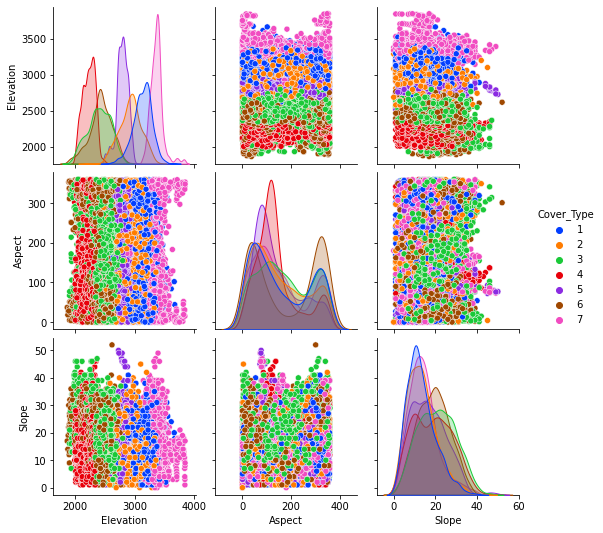

In [4]:
# Let's visualize the data we have

test_df = train[['Cover_Type', 'Elevation', "Aspect", 'Slope']]

sns.pairplot(test_df, hue='Cover_Type', palette='bright')

In [5]:
# Check the data correlation
correlation = train.corr()
correlation["Cover_Type"]

Id                                    0.108363
Elevation                             0.016090
Aspect                                0.008015
Slope                                 0.087722
Horizontal_Distance_To_Hydrology     -0.010515
Vertical_Distance_To_Hydrology        0.075647
Horizontal_Distance_To_Roadways      -0.105662
Hillshade_9am                        -0.010286
Hillshade_Noon                       -0.098905
Hillshade_3pm                        -0.053399
Horizontal_Distance_To_Fire_Points   -0.089389
Wilderness_Area1                     -0.230117
Wilderness_Area2                      0.014994
Wilderness_Area3                      0.122146
Wilderness_Area4                      0.075774
Soil_Type1                            0.015069
Soil_Type2                            0.022627
Soil_Type3                           -0.016393
Soil_Type4                           -0.027816
Soil_Type5                            0.027692
Soil_Type6                            0.006521
Soil_Type7   

In [6]:
# Clean the data

# def clean(df):
#  dropped_values = [correlation['Cover_Type'].keys()[x] for x in range(len(correlation['Cover_Type'])) if correlation['Cover_Type'][x] < -0.10]

#  dropped_values.append("Id")
 
#  df = df.drop(dropped_values, axis=1)

#  return df

# Let's generate submission file before removing Id column for the test dataframe

submission = pd.DataFrame()
submission["Id"] = test["Id"]

test = test.drop(["Id"], axis=1)
train = train.drop(["Id"], axis=1)

In [7]:
# Prepare parameters and features for the model

import math

y = train['Cover_Type']
X = train.drop(['Cover_Type'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

amnt_headers = len(train.columns)

k = np.sqrt(amnt_headers)


In [8]:
# Optimize/Tune features

from sklearn import model_selection

parameters = {"n_neighbors": range(1, 50), "weights": ['uniform', 'distance']}
gridsearch = model_selection.GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})

In [9]:
best_weights = gridsearch.best_params_['weights']
best_k = gridsearch.best_params_['n_neighbors']

In [10]:
# Train the model

knn_model = KNeighborsClassifier(n_neighbors=best_k, weights=best_weights)


In [11]:
# "Bag" it

from sklearn.ensemble import BaggingClassifier

bagging_model = BaggingClassifier(knn_model, n_estimators=100)

In [12]:
bagging_model.fit(X, y)

BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=1),
                  n_estimators=100)

In [13]:
bagging_model.score(X_test, y_test)
pred_test = bagging_model.predict(X_test)

In [14]:
pred_test

array([6, 3, 1, ..., 5, 1, 2], dtype=int64)

In [15]:
# Predict the test values

pred = bagging_model.predict(test)

In [ ]:
submission["Cover_Type"] = pred

In [ ]:
submission.to_csv("submission.csv", index=False)